In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import os
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv('sms_eng1.csv')

In [3]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.01)

In [4]:
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [5]:
train.head()

,sms,english_inp,english_out
1334,hey tmr we go your house play mahjong can,<start> hey tomorrow we go your house play mah...,hey tomorrow we go your house play mahjong can...
246,sorry forget 2 tell u think dont wan u all go ...,<start> sorry i forget to tell you i think i d...,sorry i forget to tell you i think i dont want...
260,well juz hoped you had a lovely day stay happy,<start> well just hoped you had a lovely day s...,well just hoped you had a lovely day stay happ...
1664,give me hotel tel no,<start> give me the hotel telephone number,give me the hotel telephone number <end>
1815,i think i meet darren for lunch lor then we me...,<start> i think i meet darren for lunch then w...,i think i meet darren for lunch then we meet a...


In [6]:
tokenizer_sms = Tokenizer(oov_token=True)
tokenizer_sms.fit_on_texts(train["sms"].values)
tokenizer_eng=Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_eng.fit_on_texts(train['english_inp'].values)
vocab_size_eng=len(tokenizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_sms=len(tokenizer_sms.word_index.keys())
print(vocab_size_sms)

3078
4303


In [7]:
class Dataset:
    def __init__(self, data, tokenizer_sms, tokenizer_eng, max_len):
        self.encoder_inps = data['sms'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tokenizer_eng = tokenizer_eng
        self.tokenizer_sms = tokenizer_sms
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_sms.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tokenizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data_get = []
        for j in range(start, stop):
            data_get.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1),axis=0) for samples in zip(*data_get)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [8]:
train_dataset = Dataset(train, tokenizer_sms, tokenizer_eng, 60)
test_dataset  = Dataset(validation, tokenizer_sms, tokenizer_eng, 60)

train_dataloader = Dataloder(train_dataset, batch_size=64)
test_dataloader = Dataloder(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 60) (64, 60) (64, 60)


In [9]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


In [10]:
import pickle
with open('glove_vectors', 'rb') as f:
    glove = pickle.load(f)
    glove_words =  set(glove.keys())
from numpy import zeros
vocab = len(tokenizer_eng.word_index)+1
essay_mat = zeros((vocab, 300))
for word, i in tokenizer_eng.word_index.items():
    if word in glove_words:
        vector = glove[word]
        essay_mat[i] = vector
vocab1 = len(tokenizer_sms.word_index)+1
essay_mat1 = zeros((vocab1, 300))
for word, i in tokenizer_sms.word_index.items():
    if word in glove_words:
        vector = glove[word]
        essay_mat1[i] = vector

In [11]:
encoder_inputs = Input(shape=(None,))
embedding1 = Embedding(input_dim=vocab_size_sms+1, output_dim=300, input_length=60,trainable=False,weights=[essay_mat1], name="embedding_layer_encoder")(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True,return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm(embedding1)
encoder_states = [state_h, state_c]
decoder_inputs=Input(shape=(None,))
embedding2 = Embedding(input_dim=vocab_size_eng+1, output_dim=300, input_length=60,trainable=False,weights=[essay_mat], name="embedding_layer_decoder")(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs,_,_ = decoder_lstm(embedding2,initial_state=encoder_states) 
decoder_dense = Dense(vocab_size_eng, activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)
model=Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_layer_encoder (Embedd (None, None, 300)    1291200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_layer_decoder (Embedd (None, None, 300)    923700      input_2[0][0]                    
_______________________________________________________________________________________

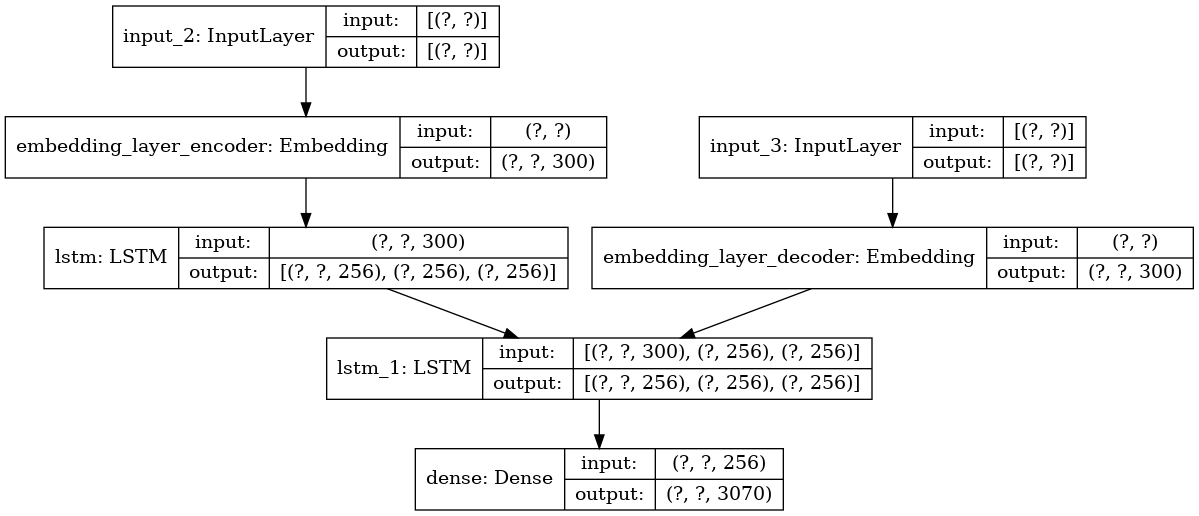

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model_beam.png', show_shapes=True, show_layer_names=True)

In [13]:
%load_ext tensorboard
log_dir="log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
red=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=1)
model.fit(train_dataloader, batch_size=64, epochs=260, validation_data=train_dataloader,callbacks=[tensorboard,red,earlystop])

Epoch 1/260
 1/30 [>.............................] - ETA: 0s - loss: 8.0329WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 31s 1s/step - loss: 3.7648 - val_loss: 1.7482
Epoch 2/260
30/30 [==============================] - 29s 971ms/step - loss: 1.6608 - val_loss: 1.5659
Epoch 3/260
30/30 [==============================] - 29s 956ms/step - loss: 1.5417 - val_loss: 1.5096
Epoch 4/260
30/30 [==============================] - 29s 973ms/step - loss: 1.5074 - val_loss: 1.4848
Epoch 5/260
30/30 [==============================] - 29s 977ms/step - loss: 1.4819 - val_loss: 1.4609
Epoch 6/260
30/30 [==============================] - 29s 968ms/step - loss: 1.4652 - val_loss: 1.4491
Epoch 7/260
30/30 [==============================]

In [14]:
def predict(input_sentence,k):
    encoder_sms=tokenizer_sms.texts_to_sequences([input_sentence])
    encoder_pad=pad_sequences(encoder_sms,maxlen=60,padding='post',dtype='int32')
    embed=model.layers[2](encoder_pad)
    encoder_out,encoder_h,encoder_c=model.layers[4](embed)
    start_index = tokenizer_eng.word_index['<start>']
    start_index=np.reshape(start_index,(1,1))
    out=[]
    for p in range(k):
        out1=[]
        for j in range(60):
            decemb=model.layers[3](start_index)
            decoder_out,decoder_h,decoder_c=model.layers[5](decemb,[encoder_h,encoder_c])
            output=model.layers[6](decoder_out)
            encoder_h,encoder_c=decoder_h,decoder_c
            output=np.array(output)
            x=output[0][0] 
            prob=x.argsort()[-k:][::-1]
            prob=prob[p]
            if prob!=0:
                out1.append(tokenizer_eng.index_word[prob])
            start_index=np.reshape(prob,(1,1))
            if prob!=0:
                if tokenizer_eng.index_word[prob]=='<end>':
                    break
        out.append(' '.join(out1))
        start_index = tokenizer_eng.word_index['<start>']
        start_index=np.reshape(start_index,(1,1))
    return out

In [15]:
%%time
from nltk.translate import bleu_score
sms_inp=validation['sms'].values
eng_inp=validation['english_out'].values
score=[]
for i in range(len(sms_inp)):
    prediction=predict(sms_inp[i],3)
    print('sms text:',sms_inp[i])
    print('correct sentence:',eng_inp[i])
    print('prediction:',prediction[0])
    score.append(bleu_score.sentence_bleu(eng_inp[i],prediction[0]))
    
print('bleu_score:',np.average(score))

sms text: same w upaul u r sprean im fr perak msia
correct sentence: same with you paul are you singaporean im from perak malaysia <end>
prediction: so are you coming to school anyway <end>
sms text: y dun u wanna go tired ah or lazy i tot today last day to reply rite still havent make up ur mind ah
correct sentence: why dont you want to go tired or lazy i told you today is the last day to reply right  you still havent made up your mind <end>
prediction: do you want to go and look not we can meet me outside because i cant get the address i also got to see you haha <end>
sms text: hmmm ya i don mind goin but she sounds like she really needs to sell e ticketsare u goin
correct sentence: hm yes i dont mind going but she sounds like she really needs to sell the tickets are you going <end>
prediction: huh dont know i dont know whether i was thinking of asking but im going to see out today is friday right <end>
sms text: oh ya r u goin to book e theory test tmr scared no more vacancies
corre